<center><h1>Parkinson disease diagnostic using time series data</h1></center>
<center><h2>Classification using machine learning</h2></center>

# Importation of librairies

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


# Import the data

In [2]:
df = pd.read_csv('preprocessed-data\preprocessed_data.csv')

df.head()

,ID,Study,Group,Subjnum,Gender,Age,Height (meters),Weight (kg),HoehnYahr,UPDRS,...,mean_swing_time_left,std_stride_left,std_swing_left,max_swing_left,min_swing_left,cv_stride_left,cv_swing_left,mean_swing_stride_ratio_left,log_left,mean_double_stance_time
0,GaPt03,Ga,PD,3,female,82,1.45,50.000000,3.0,20.0,...,0.543326,0.250426,0.124893,0.7299,0.0100,16.856355,22.986800,36.693073,-429.032245,0.935088
1,GaPt04,Ga,PD,4,male,68,1.71,72.524691,2.5,25.0,...,-0.859187,0.182767,0.161860,-0.7200,-1.8899,14.242531,-18.838775,-69.058996,96.502798,0.865798
2,GaPt05,Ga,PD,5,female,82,1.53,51.000000,2.5,24.0,...,-0.609242,0.108519,0.044731,-0.5400,-0.8200,10.185169,-7.342067,-61.899132,41.773520,0.606564
3,GaPt06,Ga,PD,6,male,72,1.70,82.000000,2.0,16.0,...,0.413048,0.051538,0.019363,0.4600,0.3000,4.494682,4.687939,36.047953,-42.744401,0.154679
4,GaPt07,Ga,PD,7,female,53,1.67,54.000000,3.0,44.0,...,0.535093,0.535390,0.079130,0.7000,0.1800,36.544871,14.788033,38.060962,-135.812348,0.592562


# Get the features and labels and encode them

In [4]:
# Separate the features and the label
X = df.drop(['ID', 'Study', 'Subjnum', 'Group'], axis=1)
y = df['Group']

# Convert the categorical label to numbers
y = y.astype('category')
y = y.cat.codes

# Convert "Gender" in X to numbers
X['Gender'] = X['Gender'].replace({'female': 0, 'male': 1})

# normalize the data
scaler = MinMaxScaler()
X[X.columns[:]] = scaler.fit_transform(X[X.columns[:]])

X.head()

,Gender,Age,Height (meters),Weight (kg),HoehnYahr,UPDRS,UPDRSM,TUAG,Speed_01 (m/sec),Speed_10,...,mean_swing_time_left,std_stride_left,std_swing_left,max_swing_left,min_swing_left,cv_stride_left,cv_swing_left,mean_swing_stride_ratio_left,log_left,mean_double_stance_time
0,0.0,0.92,0.000000,0.051724,1.000000,0.285714,0.227273,1.000000,0.646212,0.421779,...,0.987532,0.420505,0.450450,0.749988,0.867420,0.319581,0.971977,0.988728,0.060274,0.113510
1,1.0,0.64,0.001417,0.440081,0.833333,0.357143,0.181818,0.158419,0.238579,0.452454,...,0.186538,0.294175,0.596647,0.078707,0.342542,0.262351,0.388799,0.905067,0.632267,0.104723
2,0.0,0.92,0.000436,0.068966,0.833333,0.342857,0.113636,0.274660,0.463621,0.296012,...,0.329285,0.155544,0.133424,0.162045,0.638119,0.173516,0.549098,0.910731,0.572700,0.071850
3,1.0,0.72,0.001362,0.603448,0.666667,0.228571,0.295455,0.140817,0.412860,0.543712,...,0.913128,0.049153,0.033101,0.625029,0.947537,0.048924,0.716834,0.988218,0.480711,0.014548
4,0.0,0.34,0.001199,0.120690,1.000000,0.628571,0.500000,0.402192,0.268190,0.269172,...,0.982830,0.952574,0.269464,0.736145,0.914385,0.750658,0.857660,0.989811,0.379415,0.070075


In [5]:
y.head()

0    1
1    1
2    1
3    1
4    1
dtype: int8

# Classification with KNN

## Hyperparameters finetuning

### create the objective function

In [14]:
def my_KNN(k1, k2):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a KNN classifier
    clf = KNeighborsClassifier(n_neighbors=int(k2))

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [15]:
pbounds = {
    'k1': (5, 30),
    'k2': (5, 10)
    }


optimizer = BayesianOptimization(
    f=my_KNN,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |    k2     |
-------------------------------------------------
| 1         | 0.9091    | 15.43     | 8.602     |
| 2         | 0.8459    | 5.003     | 6.512     |
| 3         | 0.879     | 8.669     | 5.462     |
| 4         | 0.9091    | 9.657     | 6.728     |
| 5         | 0.9091    | 14.92     | 7.694     |
| 6         | 0.9091    | 15.48     | 8.426     |
| 7         | 0.9091    | 10.11     | 9.391     |
| 8         | 0.9093    | 5.685     | 8.352     |
| 9         | 0.8788    | 15.43     | 7.793     |
| 10        | 0.879     | 8.51      | 5.991     |
| 11        | 0.8471    | 14.61     | 8.246     |
| 12        | 0.9091    | 14.71     | 7.4       |
| 13        | 0.8783    | 8.733     | 8.144     |
| 14        | 0.9093    | 5.716     | 8.348     |
| 15        | 0.9091    | 15.94     | 8.685     |
| 16        | 0.9093    | 5.744     | 8.975     |
| 17        | 0.9093    | 6.365     | 8.802     |
| 18        | 0.9088    | 6.255     | 9.441     |


## Perform Binary classification

Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1: 0.91


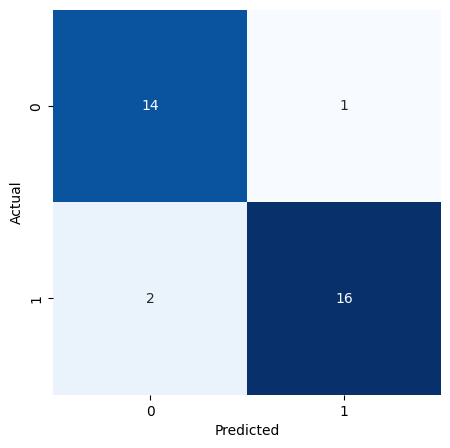

In [16]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=6)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a KNN classifier
clf = KNeighborsClassifier(n_neighbors=8)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification with Naive Bayes

## Hyperparameters finetuning

### create the objective function

In [20]:
def my_naivebayes(k1):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a Naive Bayes classifier
    clf = GaussianNB()

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [24]:
pbounds = {
    'k1': (5, 30)
    }

optimizer = BayesianOptimization(
    f=my_naivebayes,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=20, n_iter=20)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |
-------------------------------------
| 1         | 0.8165    | 15.43     |
| 2         | 0.7796    | 23.01     |
| 3         | 0.8459    | 5.003     |
| 4         | 0.8165    | 12.56     |
| 5         | 0.8165    | 8.669     |
| 6         | 0.8755    | 7.308     |
| 7         | 0.8459    | 9.657     |
| 8         | 0.8165    | 13.64     |
| 9         | 0.8165    | 14.92     |
| 10        | 0.8459    | 18.47     |
| 11        | 0.8165    | 15.48     |
| 12        | 0.7796    | 22.13     |
| 13        | 0.8459    | 10.11     |
| 14        | 0.8133    | 26.95     |
| 15        | 0.8459    | 5.685     |
| 16        | 0.7796    | 21.76     |
| 17        | 0.8165    | 15.43     |
| 18        | 0.8459    | 18.97     |
| 19        | 0.8165    | 8.51      |
| 20        | 0.8459    | 9.953     |
| 21        | 0.8459    | 6.766     |
| 22        | 0.7796    | 30.0      |
| 23        | 0.8459    | 17.28     |
| 24        | 0.8755    | 7.575     |
| 25        

## Perform Binary classification

Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1: 0.88


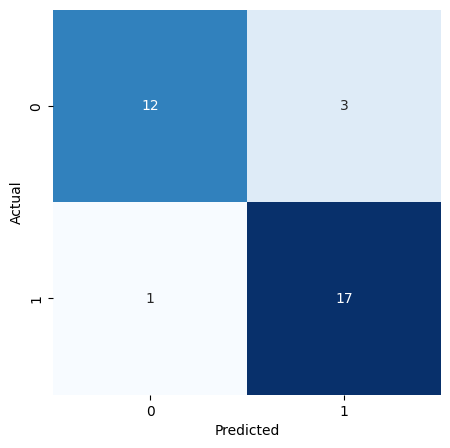

In [25]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=11)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a Naive Bayes classifier
clf = GaussianNB()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification with Decision trees

## Hyperparameters finetuning

### create the objective function

In [27]:
def my_decisiontree(k1, md, msl, mss):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a Decision Tree classifier
    clf = DecisionTreeClassifier(max_depth=int(md), min_samples_leaf=int(msl), min_samples_split=int(mss))

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [28]:
pbounds = {
    'k1': (5, 30),
    'md': (1, 10),
    'msl': (1, 10),
    'mss': (2, 10)
    }

optimizer = BayesianOptimization(
    f=my_decisiontree,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |    md     |    msl    |    mss    |
-------------------------------------------------------------------------
| 1         | 1.0       | 15.43     | 7.483     | 1.001     | 4.419     |
| 2         | 0.8783    | 8.669     | 1.831     | 2.676     | 4.764     |
| 3         | 1.0       | 14.92     | 5.849     | 4.773     | 7.482     |
| 4         | 1.0       | 10.11     | 8.903     | 1.246     | 7.364     |
| 5         | 0.9075    | 15.43     | 6.028     | 2.263     | 3.585     |
| 6         | 1.0       | 25.02     | 9.714     | 3.821     | 7.539     |
| 7         | 1.0       | 26.91     | 9.051     | 1.765     | 2.312     |
| 8         | 1.0       | 9.246     | 8.903     | 1.885     | 5.369     |
| 9         | 1.0       | 28.95     | 5.798     | 7.227     | 4.524     |
| 10        | 1.0       | 22.16     | 8.512     | 1.165     | 8.001     |
| 11        | 0.8783    | 5.193     | 2.457     | 7.384     | 8.118     |
| 12        | 1.0       | 16.06     | 

## Perform Binary classification

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00


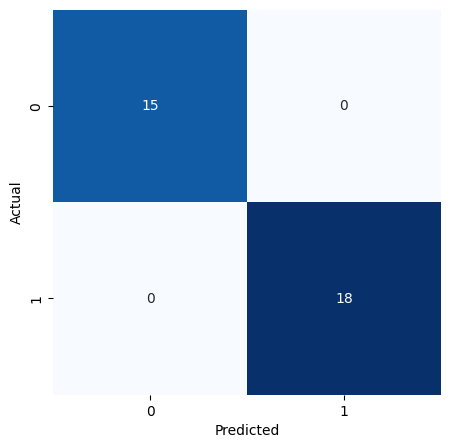

In [29]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a Decision Tree classifier
clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=1, min_samples_split=4)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification with KNN Random Forest

## Hyperparameters finetuning

### create the objective function

In [30]:
def my_randomforest(k1, md, msl, mss, n):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a Random Forest classifier
    clf = RandomForestClassifier(max_depth=int(md), min_samples_leaf=int(msl), min_samples_split=int(mss), n_estimators=int(n))

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [31]:
pbounds = {
    'k1': (5, 30),
    'md': (1, 10),
    'msl': (1, 10),
    'mss': (2, 10),
    'n': (10, 100)
    }

optimizer = BayesianOptimization(
    f=my_randomforest,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |    md     |    msl    |    mss    |     n     |
-------------------------------------------------------------------------------------
| 1         | 0.9696    | 15.43     | 7.483     | 1.001     | 4.419     | 23.21     |
| 2         | 0.9394    | 7.308     | 2.676     | 4.11      | 5.174     | 58.49     |
| 3         | 0.9696    | 15.48     | 7.167     | 2.84      | 9.025     | 12.46     |
| 4         | 0.9088    | 21.76     | 4.756     | 6.028     | 3.123     | 27.83     |
| 5         | 0.9394    | 25.02     | 9.714     | 3.821     | 7.539     | 88.88     |
| 6         | 0.9388    | 27.37     | 1.765     | 1.351     | 3.359     | 89.03     |
| 7         | 0.9388    | 7.459     | 4.79      | 9.621     | 6.265     | 72.27     |
| 8         | 0.9696    | 12.89     | 7.179     | 8.512     | 2.146     | 77.51     |
| 9         | 0.9698    | 29.72     | 7.733     | 3.524     | 8.314     | 19.29     |
| 10        | 0.9388    | 16.2      | 9.177     | 3.64

## Perform Binary classification

Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1: 0.97


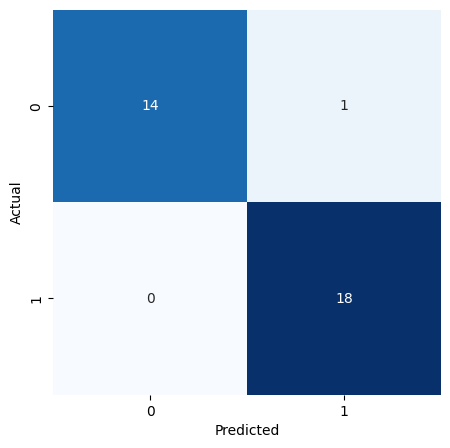

In [42]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=30)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
clf = RandomForestClassifier(max_depth=8, min_samples_leaf=4, min_samples_split=8, n_estimators=19)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification with SVM

## Hyperparameters finetuning

### create the objective function

In [47]:
def my_svm(k1, c, gamma):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a SVM classifier
    clf = SVC(C=c, gamma=gamma)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [48]:
pbounds = {
    'k1': (5, 30),
    'c': (1, 10),
    'gamma': (1, 10)
    }

optimizer = BayesianOptimization(
    f=my_svm,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=20, n_iter=20)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |     c     |   gamma   |    k1     |
-------------------------------------------------------------
| 1         | 0.8165    | 4.753     | 7.483     | 5.003     |
| 2         | 0.8165    | 3.721     | 2.321     | 7.308     |
| 3         | 0.8776    | 2.676     | 4.11      | 14.92     |
| 4         | 0.8479    | 5.849     | 4.773     | 22.13     |
| 5         | 0.8165    | 2.84      | 8.903     | 5.685     |
| 6         | 0.9088    | 7.034     | 4.756     | 18.97     |
| 7         | 0.8788    | 2.263     | 2.783     | 25.02     |
| 8         | 0.8182    | 9.714     | 3.821     | 22.31     |
| 9         | 0.8459    | 8.888     | 9.051     | 7.126     |
| 10        | 0.9388    | 1.351     | 2.528     | 26.95     |
| 11        | 0.8459    | 1.885     | 4.79      | 28.95     |
| 12        | 0.9394    | 5.798     | 7.227     | 12.89     |
| 13        | 0.8165    | 7.179     | 8.512     | 5.457     |
| 14        | 0.8084    | 7.751     | 9.9       | 23.7      |
| 15    

## Perform Binary classification

Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1: 0.94


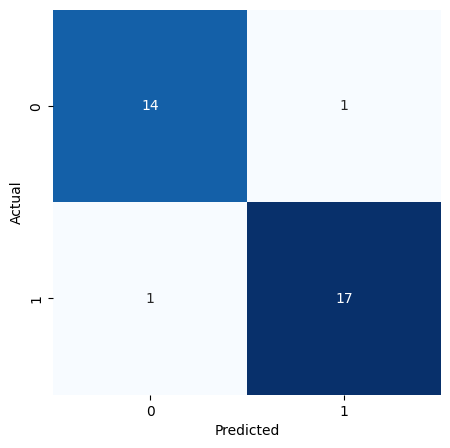

In [54]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=12)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a SVM classifier
clf = SVC(C=5.798, gamma=7.227)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()